In [25]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict, Counter
from pathlib import Path
from itertools import product
from enum import Enum
from dataclasses import dataclass
from typing import Tuple
import numpy as np
from scipy import stats
from math import sqrt

plt.style.use("ggplot")
if "snakemake" in locals() or "snakemake" in globals():
    plt.rcParams['figure.figsize'] = snakemake.params.figsize
    plt.rcParams['figure.dpi'] = snakemake.params.dpi
    csvs = snakemake.input.csvs
    qc = pd.read_csv(snakemake.input.qc)
    cov_threshold = snakemake.params.cov_threshold
    phenotypes = pd.read_csv(snakemake.input.samplesheet, index_col="run")
    ignore_drugs = snakemake.params.ignore_drugs
    CONF = snakemake.params.conf_interval
    minor_is_susceptible = snakemake.params.minor_is_susceptible
    panel_names = snakemake.params.panel_names
    outpath = snakemake.output.table
    plots = snakemake.output.plots
    who_results = pd.read_csv(snakemake.input.who_results)
else:
    plt.rcParams['figure.figsize'] = (13, 8)
    plt.rcParams['figure.dpi'] = 300
    csvs = list(Path("../../results/amr_predictions/").glob("*.csv"))
    qc = pd.read_csv("../../results/qc.csv")
    cov_threshold = 15
    phenotypes = pd.read_csv("../../docs/samplesheet.csv", index_col="run")
    ignore_drugs = {"Ciprofloxacin", "Ofloxacin"}
    CONF = 0.95
    minor_is_susceptible = False
    panel_names = {
        "previous": "Walker et al.",
        "who2021": "WHO only",
        "hunt2019": "Mykrobe",
        "hall2022": "Combined"
    }
    outpath = "table.csv"
    plots = ["plot.png"]
    who_results = pd.read_csv("../../docs/who-results.csv")

In [26]:
len(csvs)

3

In [27]:
frames = []
for p in csvs:
    frames.append(pd.read_csv(p))

df = pd.concat(frames).reset_index(drop=True)

In [28]:
passed_qc = set(qc.query("coverage >= @cov_threshold")["run"])
len(passed_qc)

8160

Remove DST results for any sample with Illumina coverage below the threshold.

In [29]:
df = df.query("run in @passed_qc")

In [30]:
class Prediction(Enum):
    Resistant = "R"
    Susceptible = "S"
    MinorResistance = "r"

    def __str__(self) -> str:
        return self.value
    
class Classification(Enum):
    TruePositive = "TP"
    FalsePositive = "FP"
    TrueNegative = "TN"
    FalseNegative = "FN"

    def __str__(self) -> str:
        return self.value
    
class Classification(Enum):
    TruePositive = "TP"
    FalsePositive = "FP"
    TrueNegative = "TN"
    FalseNegative = "FN"

    def __str__(self) -> str:
        return self.value


class Classifier:
    def __init__(
        self,
        minor_is_susceptible: bool = False,
    ):
        self.minor_is_susceptible = minor_is_susceptible
        self.susceptible = {Prediction.Susceptible}
        self.resistant = {Prediction.Resistant}
        if self.minor_is_susceptible:
            self.susceptible.add(Prediction.MinorResistance)
        else:
            self.resistant.add(Prediction.MinorResistance)


    def from_predictions(
        self, y_true: Prediction, y_pred: Prediction
    ) -> Classification:
        if y_true in self.susceptible:
            expected_susceptible = True
        elif y_true in self.resistant:
            expected_susceptible = False
        else:
            raise NotImplementedError(f"Don't know how to classify {y_true} calls yet")

        if y_pred in self.susceptible:
            called_susceptible = True
        elif y_pred in self.resistant:
            called_susceptible = False
        else:
            raise NotImplementedError(f"Don't know how to classify {y_pred} calls yet")

        if expected_susceptible and called_susceptible:
            return Classification.TrueNegative
        elif expected_susceptible and not called_susceptible:
            return Classification.FalsePositive
        elif not expected_susceptible and not called_susceptible:
            return Classification.TruePositive
        else:
            return Classification.FalseNegative

@dataclass
class ConfusionMatrix:
    tp: int = 0
    tn: int = 0
    fp: int = 0
    fn: int = 0

    def ravel(self) -> Tuple[int, int, int, int]:
        """Return the matrix as a flattened tuple.
        The order of return is TN, FP, FN, TP
        """
        return self.tn, self.fp, self.fn, self.tp

    def as_matrix(self) -> np.ndarray:
        """Returns a 2x2 matrix [[TN, FP], [FN, TP]]"""
        return np.array([[self.tn, self.fp], [self.fn, self.tp]])

    def num_positive(self) -> int:
        """Number of TPs and FNs - i.e. actual condition positive"""
        return self.tp + self.fn

    def num_negative(self) -> int:
        """Number of TNs and FPs - i.e. actual condition negative"""
        return self.tn + self.fp

    def ppv(self) -> Tuple[float, float, float]:
        """Also known as precision"""
        try:
            ppv = self.tp / (self.tp + self.fp)
            lwr_bound, upr_bound = confidence_interval(n_s=self.tp, n_f=self.fp)
            return ppv, lwr_bound, upr_bound
        except ZeroDivisionError:
            return [None, None, None]

    def npv(self) -> Tuple[float, float, float]:
        """Negative predictive value"""
        try:
            npv = self.tn / (self.tn + self.fn)
            lwr_bound, upr_bound = confidence_interval(n_s=self.tn, n_f=self.fn)
            return npv, lwr_bound, upr_bound
        except ZeroDivisionError:
            return [None, None, None]

    def sensitivity(self) -> Tuple[float, float, float]:
        """Also known as recall and true positive rate (TPR)"""
        try:
            sn =  self.tp / self.num_positive()
            lwr_bound, upr_bound = confidence_interval(n_s=self.tp, n_f=self.fn)
            return sn, lwr_bound, upr_bound
        except ZeroDivisionError:
            return None, None, None

    def specificity(self) -> Tuple[float, float, float]:
        """Also known as selectivity and true negative rate (TNR)"""
        try:
            sp = self.tn / self.num_negative()
            lwr_bound, upr_bound = confidence_interval(n_s=self.tn, n_f=self.fp)
            return sp, lwr_bound, upr_bound
        except ZeroDivisionError:
            return None, None, None

    def fnr(self) -> Tuple[float, float, float]:
        """False negative rate or VME (very major error rate)"""
        try:
            fnr = self.fn / self.num_positive()
            lwr_bound, upr_bound = confidence_interval(n_s=self.fn, n_f=self.tp)
            return fnr, lwr_bound, upr_bound
        except ZeroDivisionError:
            return [None, None, None]

    def fpr(self) -> Tuple[float, float, float]:
        """False positive rate or ME (major error rate)"""
        try:
            fpr = self.fp / self.num_negative()
            lwr_bound, upr_bound = confidence_interval(n_s=self.fp, n_f=self.tn)
            return fpr, lwr_bound, upr_bound
        except ZeroDivisionError:
            return [None, None, None]

    def f_score(self, beta: float = 1.0) -> float:
        """Harmonic mean of precision and recall.
        When beta is set to 0, you get precision. When beta is set to 1, you get the
        unweighted F-score which is the harmonic mean of precision and recall. Setting
        beta to 2 weighs recall twice as much as precision. Setting beta to 0.5 weighs
        precision twice as much as recall.
        """
        ppv = self.precision()
        tpr = self.recall()
        if ppv is None or tpr is None:
            return None
        beta2 = beta ** 2

        return ((beta2 + 1) * ppv * tpr) / ((beta2 * ppv) + tpr)

    @staticmethod
    def from_series(s: pd.Series) -> "ConfusionMatrix":
        tp = s.get("TP", 0)
        fp = s.get("FP", 0)
        fn = s.get("FN", 0)
        tn = s.get("TN", 0)
        return ConfusionMatrix(tp=tp, fn=fn, fp=fp, tn=tn)


def confidence_interval(n_s: int, n_f: int, conf: float = CONF) -> Tuple[float, float]:
    """Calculate the Wilson score interval.
    Equation take from https://en.wikipedia.org/wiki/Binomial_proportion_confidence_interval#Wilson_score_interval
    n_s: Number of successes or, in the case of confusion matrix statistics, the numerator
    n_f: Number of failures or, in the case of confusion matrix statistics, the denominator minus the numerator
    conf: the confidence level. i.e. 0.95 is 95% confidence
    """
    n = n_f + n_s
    z = stats.norm.ppf(1 - (1 - conf) / 2)  # two-sided
    z2 = z ** 2
    nz2 = n + z2
    A = (n_s + (0.5 * z2)) / nz2
    B = z / nz2
    C = sqrt(((n_s * n_f) / n) + (z2 / 4))
    CI = B * C
    return A - CI, A + CI


def round_up_to_base(x, base=10):
    return int(x + (base - x) % base)


def round_down_to_base(x, base=10):
    return int(x - (x % base))

In [31]:
df = df.query("drug not in @ignore_drugs")

In [32]:
classifier = Classifier(minor_is_susceptible=minor_is_susceptible)
classifications = []
for _, row in df.iterrows():
    drug = row["drug"].lower()
    y_true = phenotypes.at[row["run"], drug]
    if pd.isna(y_true):
        classifications.append(None)
    else:
        y_true = Prediction(y_true)
        y_pred = Prediction(row["prediction"])
        clf = classifier.from_predictions(y_true, y_pred)
        classifications.append(str(clf))

In [33]:
df["classification"] = classifications

In [34]:
df

,run,biosample,bioproject,panel,drug,prediction,classification
0,ERR036186,SAMEA897802,PRJEB2358,who2021,Delamanid,S,None
1,ERR036186,SAMEA897802,PRJEB2358,who2021,Kanamycin,S,None
2,ERR036186,SAMEA897802,PRJEB2358,who2021,Amikacin,S,None
3,ERR036186,SAMEA897802,PRJEB2358,who2021,Ethambutol,S,TN
4,ERR036186,SAMEA897802,PRJEB2358,who2021,Ethionamide,S,None
...,...,...,...,...,...,...,...
324499,SRR7131298,SAMN09090624,PRJNA438921,hall2022,Levofloxacin,S,None
324500,SRR7131298,SAMN09090624,PRJNA438921,hall2022,Pyrazinamide,S,None
324501,SRR7131298,SAMN09090624,PRJNA438921,hall2022,Linezolid,S,None
324502,SRR7131298,SAMN09090624,PRJNA438921,hall2022,Rifampicin,S,TN


In [35]:
cms = defaultdict()
DRUGS = set(df["drug"])
PANELS = set(df["panel"])

for drug, panel in product(DRUGS, PANELS):
    s = df.query("drug == @drug and panel == @panel").value_counts(
        subset=["classification"]
    )
    cm = ConfusionMatrix.from_series(s)
    cms[(drug, panel)] = cm
    
DRUGS = sorted(DRUGS)

In [36]:
metrics = []
for (drug, panel), cm in cms.items():
    sn = cm.sensitivity()[0]
    sp = cm.specificity()[0]
    metrics.append((drug, panel, sn, sp))

summary_cols = [
    "drug",
    "panel",
    "Sensitivity",
    "Specificity",
]

summary = pd.DataFrame(
    metrics,
    columns=summary_cols,
).melt(id_vars=["drug", "panel"], var_name="metric")

In [37]:
counts = df.groupby(["drug", "panel", "classification"])["run"].count()
table = summary.set_index(["drug", "panel", "metric"])["value"].unstack().reset_index()

for clf in ["TP", "FP", "FN", "TN"]:
    table[clf] = 0

for i, row in table.iterrows():
    ix = (row["drug"], row["panel"])
    cm = cms[ix]
    table.at[i, "TP"] = cm.tp
    table.at[i, "FP"] = cm.fp
    table.at[i, "TN"] = cm.tn
    table.at[i, "FN"] = cm.fn
    
for k in ["drug", "panel"]:
    table[k] = table[k].str.capitalize()

table.fillna("-", inplace=True)
summary_cols = ["drug", "panel", "Sensitivity", "Specificity", "TP", "TN", "FN", "FP"]
table = table[summary_cols]

In [38]:
rows = []
ci_str = (
    lambda tup: f"{tup[0]:.1%} ({tup[1]*100:.1f}-{tup[2]:.1%})"
    if tup[0] is not None
    else "-"
)
for i, row in table.iterrows():
    cm = ConfusionMatrix(tp=row["TP"], fp=row["FP"], tn=row["TN"], fn=row["FN"])
    sn = cm.sensitivity()
    sp = cm.specificity()
    fn_str = f"{cm.fn}({cm.num_positive()})"
    fp_str = f"{cm.fp}({cm.num_negative()})"
    rows.append(
        (
            row["drug"].capitalize(),
            panel_names[row["panel"].lower()],
            fn_str,
            fp_str,
            ci_str(sn),
            ci_str(sp),
        )
    )
pretty_cols = [
    "Drug",
    "Catalogue",
    "FN(R)",
    "FP(S)",
    "Sensitivity (95% CI)",
    "Specificity (95% CI)",
]
table = pd.DataFrame(rows, columns=pretty_cols)

In [39]:
paper_data = []
for _, row in who_results.iterrows():
    panel = panel_names["previous"]
    sn = f"{row['sensitivity']}% ({row['sensitivity_lower_bound']}%-{row['sensitivity_upper_bound']}%)"
    sp = f"{row['specificity']}% ({row['specificity_lower_bound']}%-{row['specificity_upper_bound']}%)"
    paper_data.append((row["drug"].capitalize(), panel, "-", "-", sn, sp))
paper_tbl = pd.DataFrame(paper_data, columns=table.columns)

In [40]:
table = pd.concat([paper_tbl, table]).reset_index(drop=True).sort_values(["Drug", "Catalogue"], ascending=[True, False]).reset_index(drop=True)
table

,Drug,Catalogue,FN(R),FP(S),Sensitivity (95% CI),Specificity (95% CI)
0,Amikacin,Walker et al.,-,-,77.3% (74.9%-79.5%),99.0% (98.9%-99.2%)
1,Amikacin,WHO only,48(311),38(3436),84.6% (80.1-88.2%),98.9% (98.5-99.2%)
2,Amikacin,Mykrobe,49(311),16(3436),84.2% (79.8-87.9%),99.5% (99.2-99.7%)
3,Amikacin,Combined,48(311),38(3436),84.6% (80.1-88.2%),98.9% (98.5-99.2%)
4,Capreomycin,Walker et al.,-,-,69.4% (66.4%-72.3%),98.3% (98.0%-98.6%)
5,Capreomycin,WHO only,99(319),42(3603),69.0% (63.7-73.8%),98.8% (98.4-99.1%)
6,Capreomycin,Mykrobe,98(319),39(3603),69.3% (64.0-74.1%),98.9% (98.5-99.2%)
7,Capreomycin,Combined,99(319),42(3603),69.0% (63.7-73.8%),98.8% (98.4-99.1%)
8,Delamanid,Walker et al.,-,-,6.1% (2.0%-13.7%),100.0% (99.9%-100.0%)
9,Delamanid,WHO only,42(42),0(492),0.0% (0.0-8.4%),100.0% (99.2-100.0%)


In [41]:
sn_data = []
sp_data = []
for drug, panel in product(DRUGS, PANELS):
    s = df.query("drug == @drug and panel == @panel").value_counts(
        subset=["classification"]
    )
    cm = ConfusionMatrix.from_series(s)
    sn = cm.sensitivity()
    sp = cm.specificity()
    sn_data.append((drug, panel, *sn))
    sp_data.append((drug, panel, *sp))
    
sn_df = pd.DataFrame(sn_data, columns=["drug", "panel", "value", "lower", "upper"])
sp_df = pd.DataFrame(sp_data, columns=["drug", "panel", "value", "lower", "upper"])

In [42]:
DRUGS

['Amikacin',
 'Capreomycin',
 'Delamanid',
 'Ethambutol',
 'Ethionamide',
 'Isoniazid',
 'Kanamycin',
 'Levofloxacin',
 'Linezolid',
 'Moxifloxacin',
 'Pyrazinamide',
 'Rifampicin',
 'Streptomycin']

In [43]:
sensitivities = []
for d in DRUGS:
    sensitivities.append(np.mean(sn_df.query("drug==@d")["value"]))
sensitivities = np.array(sensitivities)
drugix = np.array(list(reversed(np.argsort(sensitivities))))
ordered_drugs = np.array(DRUGS)[drugix]

In [44]:
def sort_drugs(a):
    xs = [d.lower() for d in ordered_drugs.tolist()]
    out = []
    c = Counter()
    for x in a:
        i = xs.index(x.lower())
        d = xs[i]
        c[d] += 1
        out.append((i, c[d]))
    return out

In [45]:
sn_df = sn_df.sort_values(by="drug", key=sort_drugs).reset_index(drop=True)
sp_df = sp_df.sort_values(by="drug", key=sort_drugs).reset_index(drop=True)

In [46]:
s = """AMK amikacin
BDQ bedaquiline
CAP capreomycin
CFZ clofazimine
CFX ciprofloxacin
DLM delamanid
EMB ethambutol
ETO ethionamide
FQ fluoroquinolone
INH isoniazid
KAN kanamycin
LFX levofloxacin
LZD linezolid
MFX moxifloxacin
OFX ofloxacin
PTO prothionamide
PZA pyrazinamide
RIF rifampicin
STM streptomycin"""
abbrev = dict()
for line in s.splitlines():
    ab, d = line.split()
    abbrev[d.capitalize()] = ab
abbrev

{'Amikacin': 'AMK',
 'Bedaquiline': 'BDQ',
 'Capreomycin': 'CAP',
 'Clofazimine': 'CFZ',
 'Ciprofloxacin': 'CFX',
 'Delamanid': 'DLM',
 'Ethambutol': 'EMB',
 'Ethionamide': 'ETO',
 'Fluoroquinolone': 'FQ',
 'Isoniazid': 'INH',
 'Kanamycin': 'KAN',
 'Levofloxacin': 'LFX',
 'Linezolid': 'LZD',
 'Moxifloxacin': 'MFX',
 'Ofloxacin': 'OFX',
 'Prothionamide': 'PTO',
 'Pyrazinamide': 'PZA',
 'Rifampicin': 'RIF',
 'Streptomycin': 'STM'}

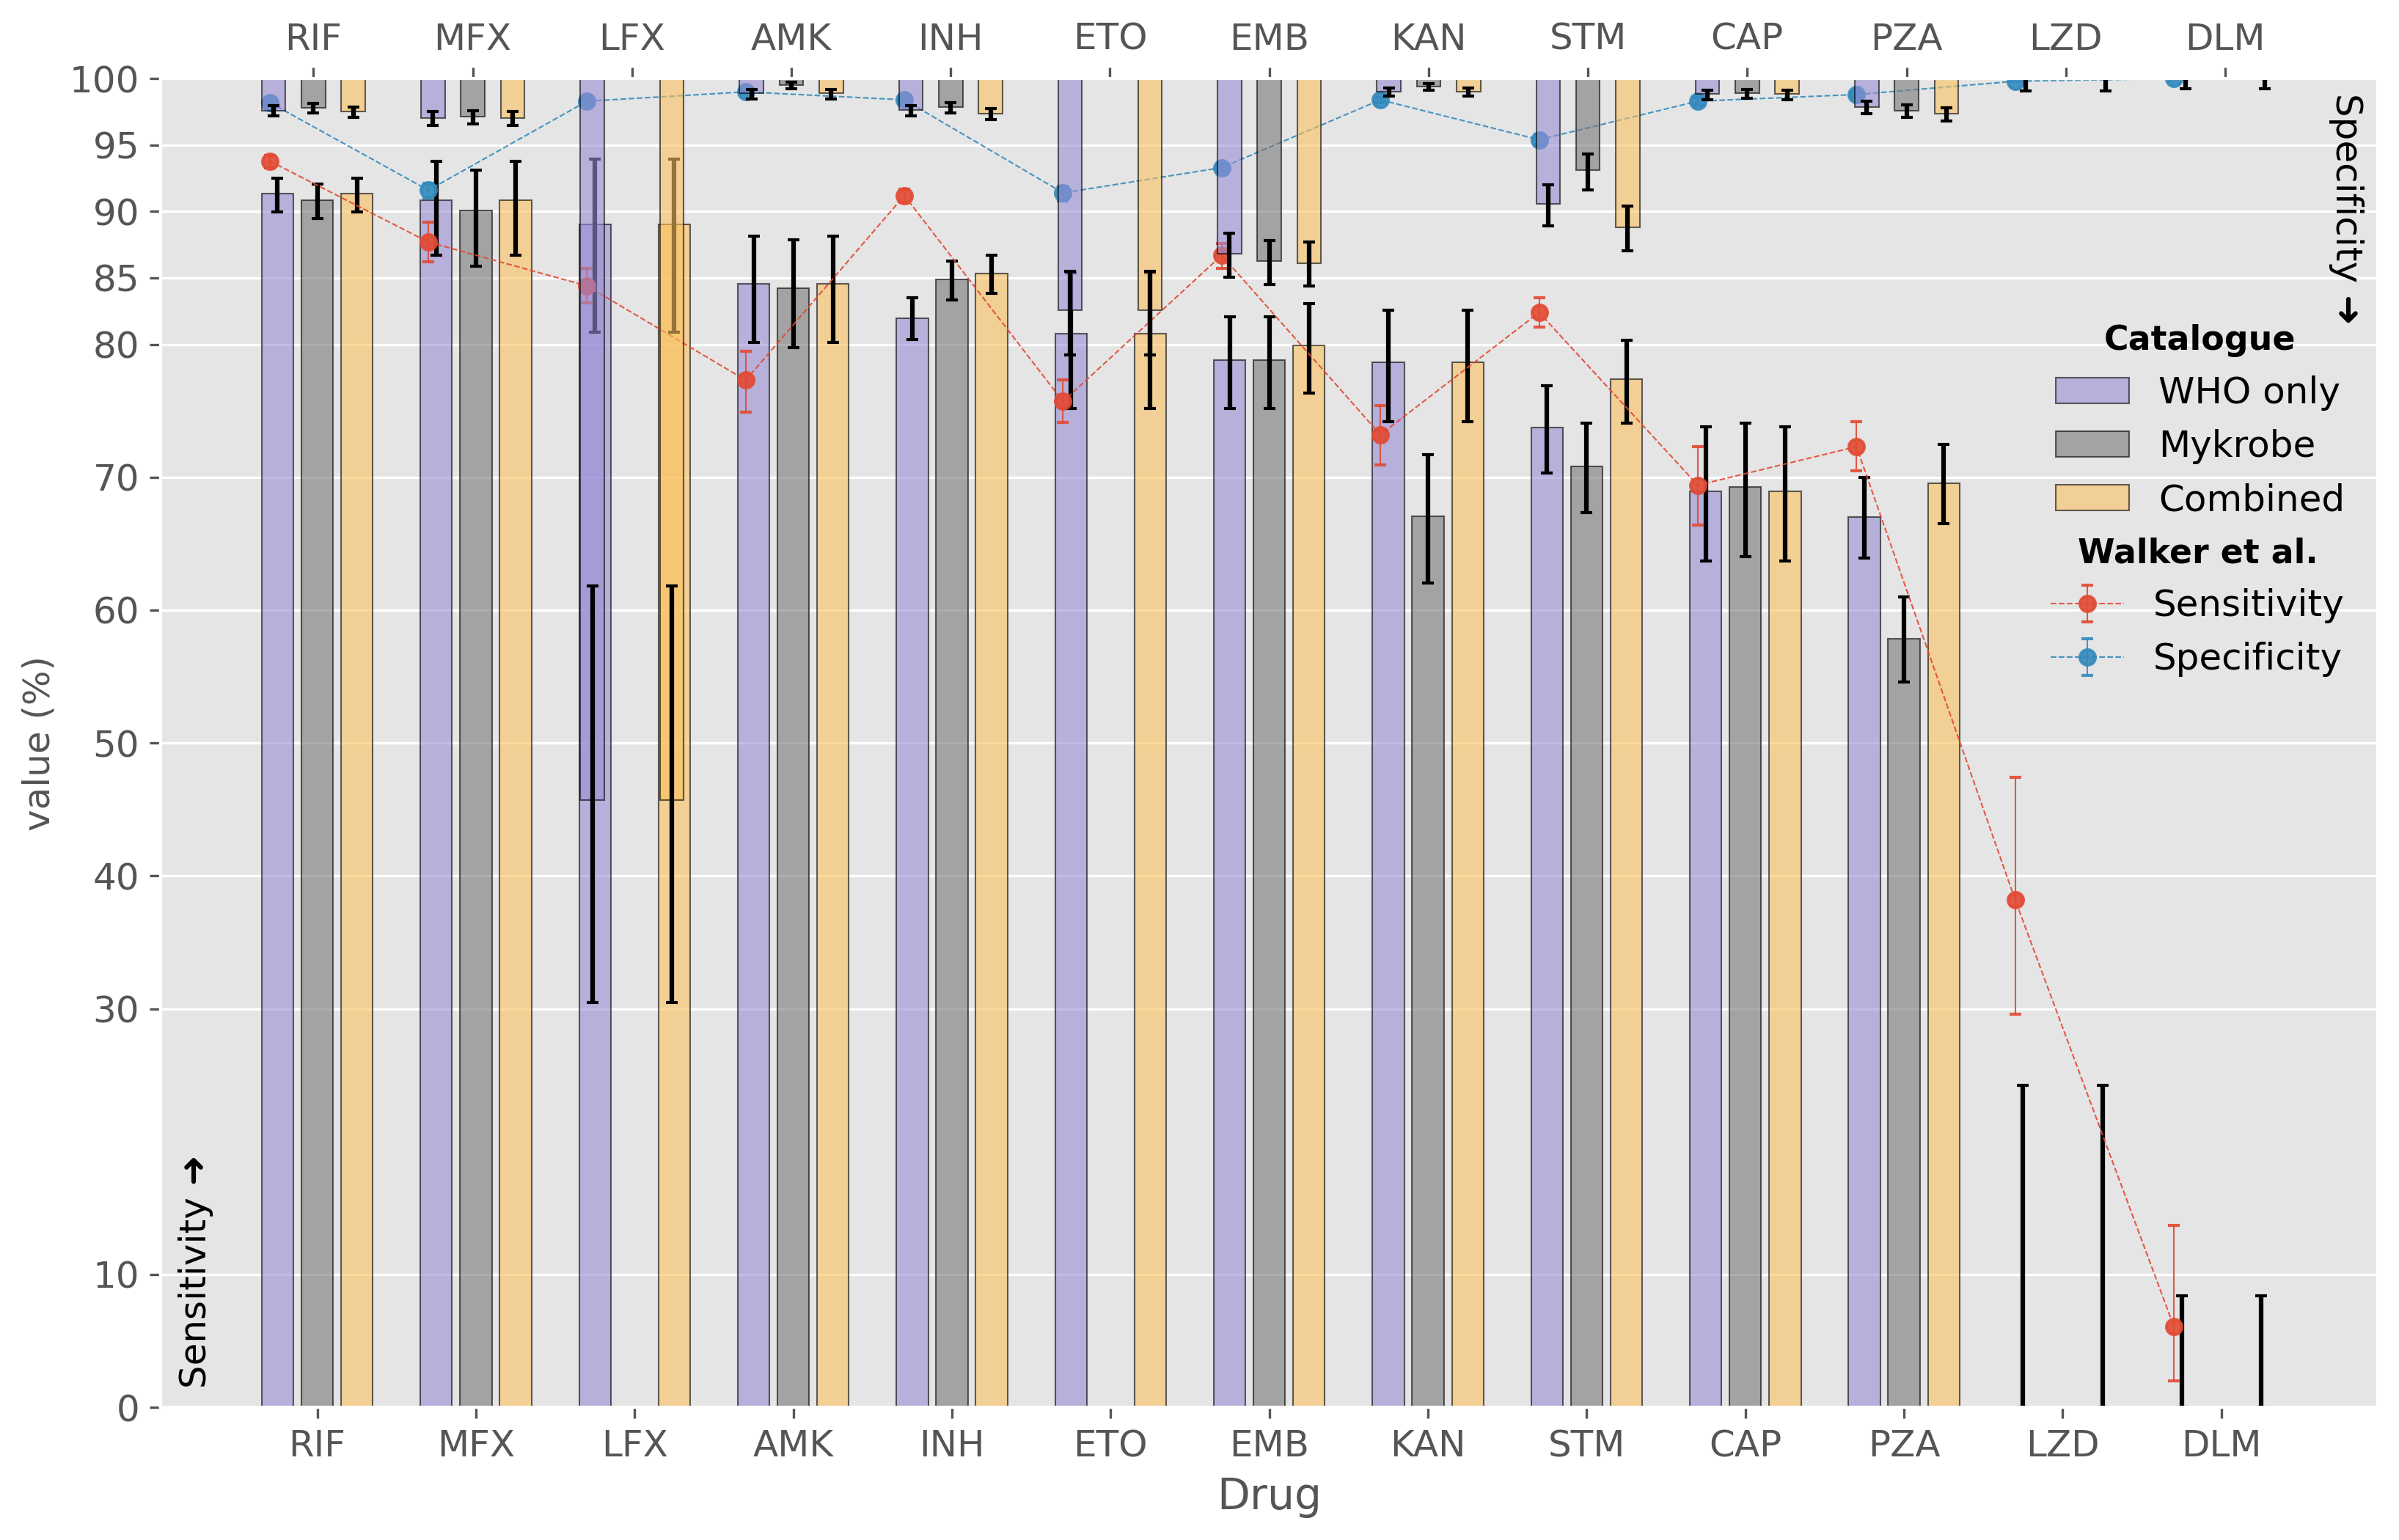

In [61]:
fig, axR = plt.subplots(figsize=(13, 8), dpi=300)
axS = axR.twiny()
ggplot_cm = plt.rcParams["axes.prop_cycle"].by_key()["color"]
red = ggplot_cm[0]
blue = ggplot_cm[1]
purple = ggplot_cm[2]
black = ggplot_cm[3]
yellow = ggplot_cm[4]
green = ggplot_cm[5]
edgecol = "black"
cmap = [purple, black, yellow]
# plot details
bar_width = 0.2
epsilon = 0.05
line_width = 0.5
fs = 12
rotate = 0
capsize = 2
alpha = 1.0
bar_alpha = 0.6
hatch = ""

all_positions = []
i = -1
for panel in panel_names:
    if panel == "previous":
        continue
    i += 1
    ix = (d, panel)
    panel_sn_df = sn_df.query("panel==@panel")
    sn_ys = panel_sn_df["value"] * 100
    sn_lb = sn_ys - panel_sn_df["lower"] * 100
    sn_ub = panel_sn_df["upper"] * 100 - sn_ys
    
    positions = [p + ((bar_width + epsilon) * i) for p in np.arange(len(sn_ys))]
    if panel == "who2021":
        who_positions = np.array(positions)
        
    all_positions.append(positions)
    
    colour = cmap[i]
    label = panel_names[panel.lower()]

    # resistance bar plots
    sn_bar = axR.bar(
        positions,
        sn_ys,
        bar_width,
        yerr=[sn_lb, sn_ub],
        color=colour,
        edgecolor=edgecol,
        linewidth=line_width,
        capsize=capsize,
        alpha=bar_alpha,
        label=label,
    )

    panel_sp_df = sp_df.query("panel==@panel")
    sp_ys = panel_sp_df["value"] * 100
    sp_lb = sp_ys - panel_sp_df["lower"] * 100
    sp_ub = panel_sp_df["upper"] * 100 - sp_ys
    sp_ub = [min(100, x) for x in sp_ub]
    
    sp_bar = axS.bar(
        positions,
        height=-(100-sp_ys),
        bottom=100,
        width=bar_width*0.75,
        yerr=[sp_lb, sp_ub],
        alpha=bar_alpha,
        color=colour,
        edgecolor=edgecol,
        linewidth=line_width,
        capsize=capsize,
        error_kw=dict(barsabove=True),
        label=label,
    )
    


# add errorbars for paper sensitivity
paper_cat = panel_names["previous"]
paper_df = who_results.sort_values(by="drug", key=sort_drugs).reset_index(drop=True)
offset = 0.05
xs = who_positions-offset#[np.mean(ps)-0.1 for ps in zip(*all_positions)]
metric = "sensitivity"
ys = np.array(paper_df[metric])
yerr_l = ys - paper_df[f"{metric}_lower_bound"]
yerr_u = paper_df[f"{metric}_upper_bound"] - ys
yerr_u = [min(100, x) for x in yerr_u]
MS = 10
axR.errorbar(
    xs, 
    ys, 
    yerr=[yerr_l, yerr_u], 
    color=red, 
    capsize=capsize, 
    fmt=".--", 
    alpha=0.9, 
    linewidth=line_width,
    label=metric.capitalize(),
    ms=MS,
)

# add errorbars for paper specificity
paper_cat = panel_names["previous"]
paper_df = who_results.sort_values(by="drug", key=sort_drugs).reset_index(drop=True)
metric = "specificity"
ys = np.array(paper_df[metric])
yerr_l = ys - paper_df[f"{metric}_lower_bound"]
yerr_u = paper_df[f"{metric}_upper_bound"] - ys
yerr_u = [min(100, x) for x in yerr_u]

axR.errorbar(
    xs, 
    ys, 
    yerr=[yerr_l, yerr_u], 
    color=blue, 
    capsize=capsize, 
    fmt=".--", 
    alpha=0.9, 
    linewidth=line_width,
    label=metric.capitalize(),
    ms=MS,
)
    
labels = [abbrev[d] for d in ordered_drugs]
label_pos = [np.mean(ps) for ps in zip(*all_positions)]
plt.xticks(label_pos, labels, rotation=rotate, fontsize=fs)
axR.set_ylabel("value (%)")
yticks = [0, 10, 30, 40, 50, 60, 70, 80, 85, 90, 95, 100]
axR.set_yticks(yticks)
axR.set_yticklabels(yticks)
axR.set_xticks(label_pos)
axR.set_xticklabels(axS.get_xticklabels(), rotation=rotate, fontsize=fs)
axR.tick_params("both", labelsize=fs)

plt.text(-0.6, 2,
    "Sensitivity ➜", 
    rotation="vertical", 
    fontsize=fs,
)
plt.text(12.9, 82,
    "Specificity ➜", 
    rotation=270, 
    fontsize=fs,
)

leghandles, leglabels = axR.get_legend_handles_labels()
legend_props = dict(loc="upper right", prop=dict(size=fs), frameon=False, title_fontproperties=dict(size=fs-1, weight="bold"))
axR.legend(leghandles[:-2], leglabels[:-2], title="Catalogue", bbox_to_anchor=(1, 0.84), **legend_props)
axS.legend(leghandles[-2:], leglabels[-2:], title="Walker et al.", bbox_to_anchor=(1, 0.68), **legend_props)
axS.grid(False)
axR.grid(False, axis="x",)
_ = axR.set_xlabel("Drug", fontsize=fs+2)

In [63]:
# fig.savefig("../../docs/submission/figure1.svg")

In [ ]:
for plot_path in plots:
    fig.savefig(plot_path)

In [67]:
print(table.to_latex(index=False).replace(".", "·").replace("l·", "l.").replace("et al.", "\etal{}"))

\begin{tabular}{llllll}
\toprule
        Drug &     Catalogue &     FN(R) &     FP(S) & Sensitivity (95\% CI) &  Specificity (95\% CI) \\
\midrule
    Amikacin & Walker \etal{} &         - &         - &  77·3\% (74·9\%-79·5\%) &   99·0\% (98·9\%-99·2\%) \\
    Amikacin &      WHO only &   48(311) &  38(3436) &   84·6\% (80·1-88·2\%) &    98·9\% (98·5-99·2\%) \\
    Amikacin &       Mykrobe &   49(311) &  16(3436) &   84·2\% (79·8-87·9\%) &    99·5\% (99·2-99·7\%) \\
    Amikacin &      Combined &   48(311) &  38(3436) &   84·6\% (80·1-88·2\%) &    98·9\% (98·5-99·2\%) \\
 Capreomycin & Walker \etal{} &         - &         - &  69·4\% (66·4\%-72·3\%) &   98·3\% (98·0\%-98·6\%) \\
 Capreomycin &      WHO only &   99(319) &  42(3603) &   69·0\% (63·7-73·8\%) &    98·8\% (98·4-99·1\%) \\
 Capreomycin &       Mykrobe &   98(319) &  39(3603) &   69·3\% (64·0-74·1\%) &    98·9\% (98·5-99·2\%) \\
 Capreomycin &      Combined &   99(319) &  42(3603) &   69·0\% (63·7-73·8\%) &    98·8\% (98·4-99

In [65]:
with open(outpath, "w") as fp:
    print(table.to_csv(index=False).replace(".", "·").replace("l·", "l."), file=fp)

In [64]:
for drug in set(table["Drug"]):
    print(drug)
    rows = table.query("Drug==@drug and Catalogue in ['Mykrobe', 'Combined']").sort_values("Catalogue", ascending=False)
    sn1 = rows["Sensitivity (95% CI)"].iloc[0].split()[0][:-1]
    if not sn1:
        continue
    sn1 = float(sn1)
    sn2 = float(rows["Sensitivity (95% CI)"].iloc[1].split()[0][:-1])
    sndiff = sn1-sn2
    sp1 = float(rows["Specificity (95% CI)"].iloc[0].split()[0][:-1])
    sp2 = float(rows["Specificity (95% CI)"].iloc[1].split()[0][:-1])
    spdiff = sp1-sp2
    print(f"Sn diff. {sndiff:.1f}\tSp diff. {spdiff:.1f}")

Kanamycin
Sn diff. -11.7	Sp diff. 0.4
Ethambutol
Sn diff. -1.1	Sp diff. 0.1
Pyrazinamide
Sn diff. -11.8	Sp diff. 0.2
Isoniazid
Sn diff. -0.4	Sp diff. 0.4
Streptomycin
Sn diff. -6.6	Sp diff. 4.3
Ethionamide
Delamanid
Amikacin
Sn diff. -0.4	Sp diff. 0.6
Capreomycin
Sn diff. 0.3	Sp diff. 0.1
Levofloxacin
Linezolid
Rifampicin
Sn diff. -0.5	Sp diff. 0.3
Moxifloxacin
Sn diff. -0.7	Sp diff. 0.1


In [70]:
sn_df.query("panel=='who2021'").to_csv("../../pvalues/sn_who.csv", index=False)

In [71]:
sp_df.query("panel=='who2021'").to_csv("../../pvalues/sp_who.csv", index=False)

In [76]:
table.rename(columns={"Catalogue": "Panel"}).query("Panel!='Walker et al.'").to_csv("../../pvalues/results.csv", index=False)

In [75]:
table

,Drug,Catalogue,FN(R),FP(S),Sensitivity (95% CI),Specificity (95% CI)
0,Amikacin,Walker et al.,-,-,77.3% (74.9%-79.5%),99.0% (98.9%-99.2%)
1,Amikacin,WHO only,48(311),38(3436),84.6% (80.1-88.2%),98.9% (98.5-99.2%)
2,Amikacin,Mykrobe,49(311),16(3436),84.2% (79.8-87.9%),99.5% (99.2-99.7%)
3,Amikacin,Combined,48(311),38(3436),84.6% (80.1-88.2%),98.9% (98.5-99.2%)
4,Capreomycin,Walker et al.,-,-,69.4% (66.4%-72.3%),98.3% (98.0%-98.6%)
5,Capreomycin,WHO only,99(319),42(3603),69.0% (63.7-73.8%),98.8% (98.4-99.1%)
6,Capreomycin,Mykrobe,98(319),39(3603),69.3% (64.0-74.1%),98.9% (98.5-99.2%)
7,Capreomycin,Combined,99(319),42(3603),69.0% (63.7-73.8%),98.8% (98.4-99.1%)
8,Delamanid,Walker et al.,-,-,6.1% (2.0%-13.7%),100.0% (99.9%-100.0%)
9,Delamanid,WHO only,42(42),0(492),0.0% (0.0-8.4%),100.0% (99.2-100.0%)
